In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.patches as patches
import pandas as pd
from astropy import units as u
from astropy import visualization as aviz
import pandas as pd
import numpy.ma as ma
import matplotlib
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from matplotlib import rcParams

cm = matplotlib.cm.get_cmap('jet')

%matplotlib inline
%config InlineBackend.figure_format = "retina"
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

# TAP service
from lsst.rsp import get_tap_service, retrieve_query

import astropy.units as u
from astropy.table import Table
from astropy import visualization as aviz

import lsst.daf.butler as dafButler
import lsst.geom
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
import lsst.afw.cameraGeom as cameraGeom
from lsst.obs.decam import DarkEnergyCamera
import lsst.daf.butler as dafButler
import lsst.geom
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
import lsst.afw.cameraGeom as cameraGeom
from lsst.obs.decam import DarkEnergyCamera

import functools
import operator
import os
from deprecated.sphinx import deprecated

import sqlite3

import psycopg2
from psycopg2 import sql
import pandas as pd

from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
import lsst.daf.butler as dafButler

# BOKEH stuf
from bokeh.models import Dropdown
from bokeh.io import output_notebook
from bokeh.resources import INLINE
output_notebook(INLINE)
from bokeh.models import HoverTool
##### DEMO ##### 
from bokeh.models import ColumnDataSource
from bokeh.plotting import ColumnDataSource, figure, output_file, show
from bokeh.plotting import figure, output_file, save, reset_output

from sklearn import datasets
from bokeh.plotting import figure, show, output_notebook
import ipywidgets as widgets
from IPython.display import display, clear_output 
from sklearn import datasets
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show, output_notebook
import ipywidgets as widgets
from IPython.display import display, clear_output
output_notebook() 

from bokeh.io import curdoc

Loading BokehJS ...

Loading BokehJS ...

## TAP Service Client

In [25]:
# create the TAP service client
service = get_tap_service()

# we will all use the same input coordinates and radii
center_coords = "58, -30"

radius_deg = 1 # degrees

## DIAObject Query

In [26]:
results = service.search("SELECT ra, decl, gPSFluxSigma, rPSFluxSigma, nDiaSources, diaObjectId, "
                         "uPSFluxNdata, gPSFluxNdata, rPSFluxNdata, iPSFluxNdata, zPSFluxNdata, yPSFluxNdata, rPSFluxMax, "
                         "scisql_nanojanskyToAbMag(uPSFluxMax) as u_psf_mag, "
                         "scisql_nanojanskyToAbMag(gPSFluxMax) as g_psf_mag, "
                         "scisql_nanojanskyToAbMag(rPSFluxMax) as r_psf_mag, "
                         "scisql_nanojanskyToAbMag(iPSFluxMax) as i_psf_mag, "
                         "scisql_nanojanskyToAbMag(zPSFluxMax) as z_psf_mag, "
                         "scisql_nanojanskyToAbMag(yPSFluxMax) as y_psf_mag "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                         f"CIRCLE('ICRS', {center_coords}, {radius_deg})) = 1 "
                        "AND uPSFluxChi2 > 0 "
                        "AND gPSFluxChi2 > 0 "
                        "AND rPSFluxChi2 > 0 "
                        "AND iPSFluxChi2 > 0 "
                        "AND zPSFluxChi2 > 0 "
                        "AND yPSFluxChi2 > 0 ")

table = results.to_table()

In [27]:
def xmatch_diasource(cent_coord, diaObjID, rad=0.1):
    """ Crossmatch DIAObjectID to the DiaSoure table given the coordinates and DIAObjectiID. 
    
        Parameters
        ----------
            cent_coord (str): ra, dec coordinates in degrees
            diaObjID (int): DiaObjectID
            rad (float): Crossmatch radius. Default is 0.1 degrees.
        
        Returns 
        -------
            DiaSouce Table (astropy.Table)
    """
    
    return service.search(f"SELECT ra, decl, filterName, ccdVisitId "
                  "FROM dp02_dc2_catalogs.DiaSource "
                 "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                 f"CIRCLE('ICRS', {cent_coord}, {rad})) = 1 "
                  f"AND diaObjectId = {diaObjID}").to_table()


def xmatch_source(cent_coord, ccd_vis, rad=0.01):
    """ Crossmatch CCD Visit ID from the DiaSource to the Source table.

    Parameters
    ----------
        cent_coord (str): ra, dec coordinates in degrees
        ccd_vis (int): CCD visit ID
        rad (float): Crossmatch radius. Default is 0.01 degrees.

    Returns 
    -------
        Source Table (astropy.Table)
    """

    _table = service.search(f"SELECT ra, decl, coord_ra, coord_dec, ccdVisitId, "
              "band, instrument, "
              "visit, sourceId, detector "
          "FROM dp02_dc2_catalogs.Source "
         "WHERE CONTAINS(POINT('ICRS', ra, decl), "
         f"CIRCLE('ICRS', {cent_coord}, {rad})) = 1 "
          f"AND ccdVisitId = {ccd_vis}").to_table()

    # In crowded fields we suspect this will cause issues; let's to the closest x-match based on location
    targ_pos = SkyCoord(ra=float(cent_coord.split(",")[0])*u.deg, dec=float(cent_coord.split(",")[1])*u.deg)
    table_pos = SkyCoord(ra=_table['ra'], dec=_table['decl'])    
    d_sep = targ_pos.separation(table_pos).arcsecond

    match = np.argmin(d_sep)
    return _table[match]


def DiaSouceOID(dia_ID, columns="*", band='r', center_coords=center_coords, rad=1):
    """ Given the DiaObjectiD this function will return the DiaSource catalog for a specific photometric filter and crossmatch radius. 

    Parameters
    ----------
        dia_ID (int): DiaObjectID
        columns (str): Supports all columns listed in the DP02 columns page. Default is all columns (*).
        band (str): Photometric LSST band - supports ugrizy. Default r. For all photometric filters use 'all'
        center_coords (str): Central coordinates of query. 
        rad (float): crossmatch radius. Default is 1 deg.

    Returns 
    -------
        DiaSource Table (astropy.Table)
    """
    _table = service.search(f"SELECT {columns} "
                      "FROM dp02_dc2_catalogs.DiaSource "
                     "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                     f"CIRCLE('ICRS', {center_coords}, {rad})) = 1 "
                      f"AND diaObjectId = {dia_ID}").to_table()
    if band=='all':
        return _table
    else:
        return _table[_table['filterName']==band]

## Visualizing DiaObjets

In [28]:
results = service.search("SELECT *, "
                         "scisql_nanojanskyToAbMag(uPSFluxMax) as u_psf_mag, "
                         "scisql_nanojanskyToAbMag(gPSFluxMax) as g_psf_mag, "
                         "scisql_nanojanskyToAbMag(rPSFluxMax) as r_psf_mag, "
                         "scisql_nanojanskyToAbMag(iPSFluxMax) as i_psf_mag, "
                         "scisql_nanojanskyToAbMag(zPSFluxMax) as z_psf_mag, "
                         "scisql_nanojanskyToAbMag(yPSFluxMax) as y_psf_mag "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                         f"CIRCLE('ICRS', {center_coords}, {radius_deg})) = 1 "
                        "AND uPSFluxChi2 > 0 "
                        "AND gPSFluxChi2 > 0 "
                        "AND rPSFluxChi2 > 0 "
                        "AND iPSFluxChi2 > 0 "
                        "AND zPSFluxChi2 > 0 "
                        "AND yPSFluxChi2 > 0 ")

table = results.to_table()

In [29]:
data = table.to_pandas()

In [36]:
# Helper functions
def var_dropdown2(x):
    """This function is executed when a dropdown value is changed.
    It creates a new figure according to the new dropdown values."""
    p = create_figure2(
    x_dropdown.children[0].value,
    y_dropdown.children[0].value,
    data)
    
    fig[0] = p

    with output_figure:
        clear_output(True)
        show(fig[0])
    fig[0]=p

    return x


def create_figure2(x_var, y_var, data):
    """This is a helper function that creates a new figure and 
    plots values from all three species. x_var and y_var control
    the features on each axis."""
    species_colors=['cyan', 'green', 'red', 'orange', 'purple', 'black']

    # Set-up figure
    p = figure(title="",
               x_axis_label=x_var,
               y_axis_label=y_var)

    circle = p.circle(
        data[x_var],
        data[y_var],
        color='mediumpurple',
        size=5)

    return p

In [64]:
# The output widget is where we direct our figures
output_figure = widgets.Output()

# Create the default figure
fig = []
p = create_figure2(
    data.columns[2],
    data.columns[3],
    data)
fig.append(p)
with output_figure:
    show(fig[0])

"""Create the widgets in the menu"""
# Dropdown menu for x-axis feature.
x_dropdown = widgets.interactive(var_dropdown2,
                                 x=data.columns);
x_dropdown.children[0].description = 'x-axis'
x_dropdown.children[0].value = data.columns[0]

# Dropdown menu for y-axis feature.
y_dropdown = widgets.interactive(var_dropdown2,
                                 x=data.columns);
y_dropdown.children[0].description = 'y-axis'
y_dropdown.children[0].value = data.columns[1]


# This creates the menu 
menu=widgets.VBox([x_dropdown,
                   y_dropdown])

"""Create the full app with menu and output"""
# The Layout adds some styling to our app.
# You can add Layout to any widget.
app_layout = widgets.Layout(display='flex',
                flex_flow='row nowrap',
                align_items='center',
                border='none',
                width='100%',
                margin='5px 5px 5px 5px')

# The final app is just a box
app=widgets.Box([menu, output_figure], layout=app_layout)

# Display the app
display(app)

Box(children=(VBox(children=(interactive(children=(Dropdown(description='x-axis', options=('decl', 'diaObjectI…

In [ ]:
for flt in tqdm(list('ugizy')):
    
    _cols = [col for col in data.columns if col.startswith(flt)]

    # create a correlation-like data set stored in a Pandas' dataframe.
    import string
    # letters = string.uppercase[0:10] # python2
    letters = string.ascii_uppercase[0:10]
    import pandas as pd


    # and use corrplot
    from biokit.viz import corrplot
    fig = plt.figure(figsize=(35, 20))
    c = corrplot.Corrplot(data.loc[:,_cols])
    c.plot(fig)
    plt.title(f"LSST-{flt}", fontsize=35)
    plt.savefig(f"conf_m{flt}.jpg", dpi=800, format='jpg')

  0%|          | 0/5 [00:00<?, ?it/s]

Computing correlation


Computing correlation


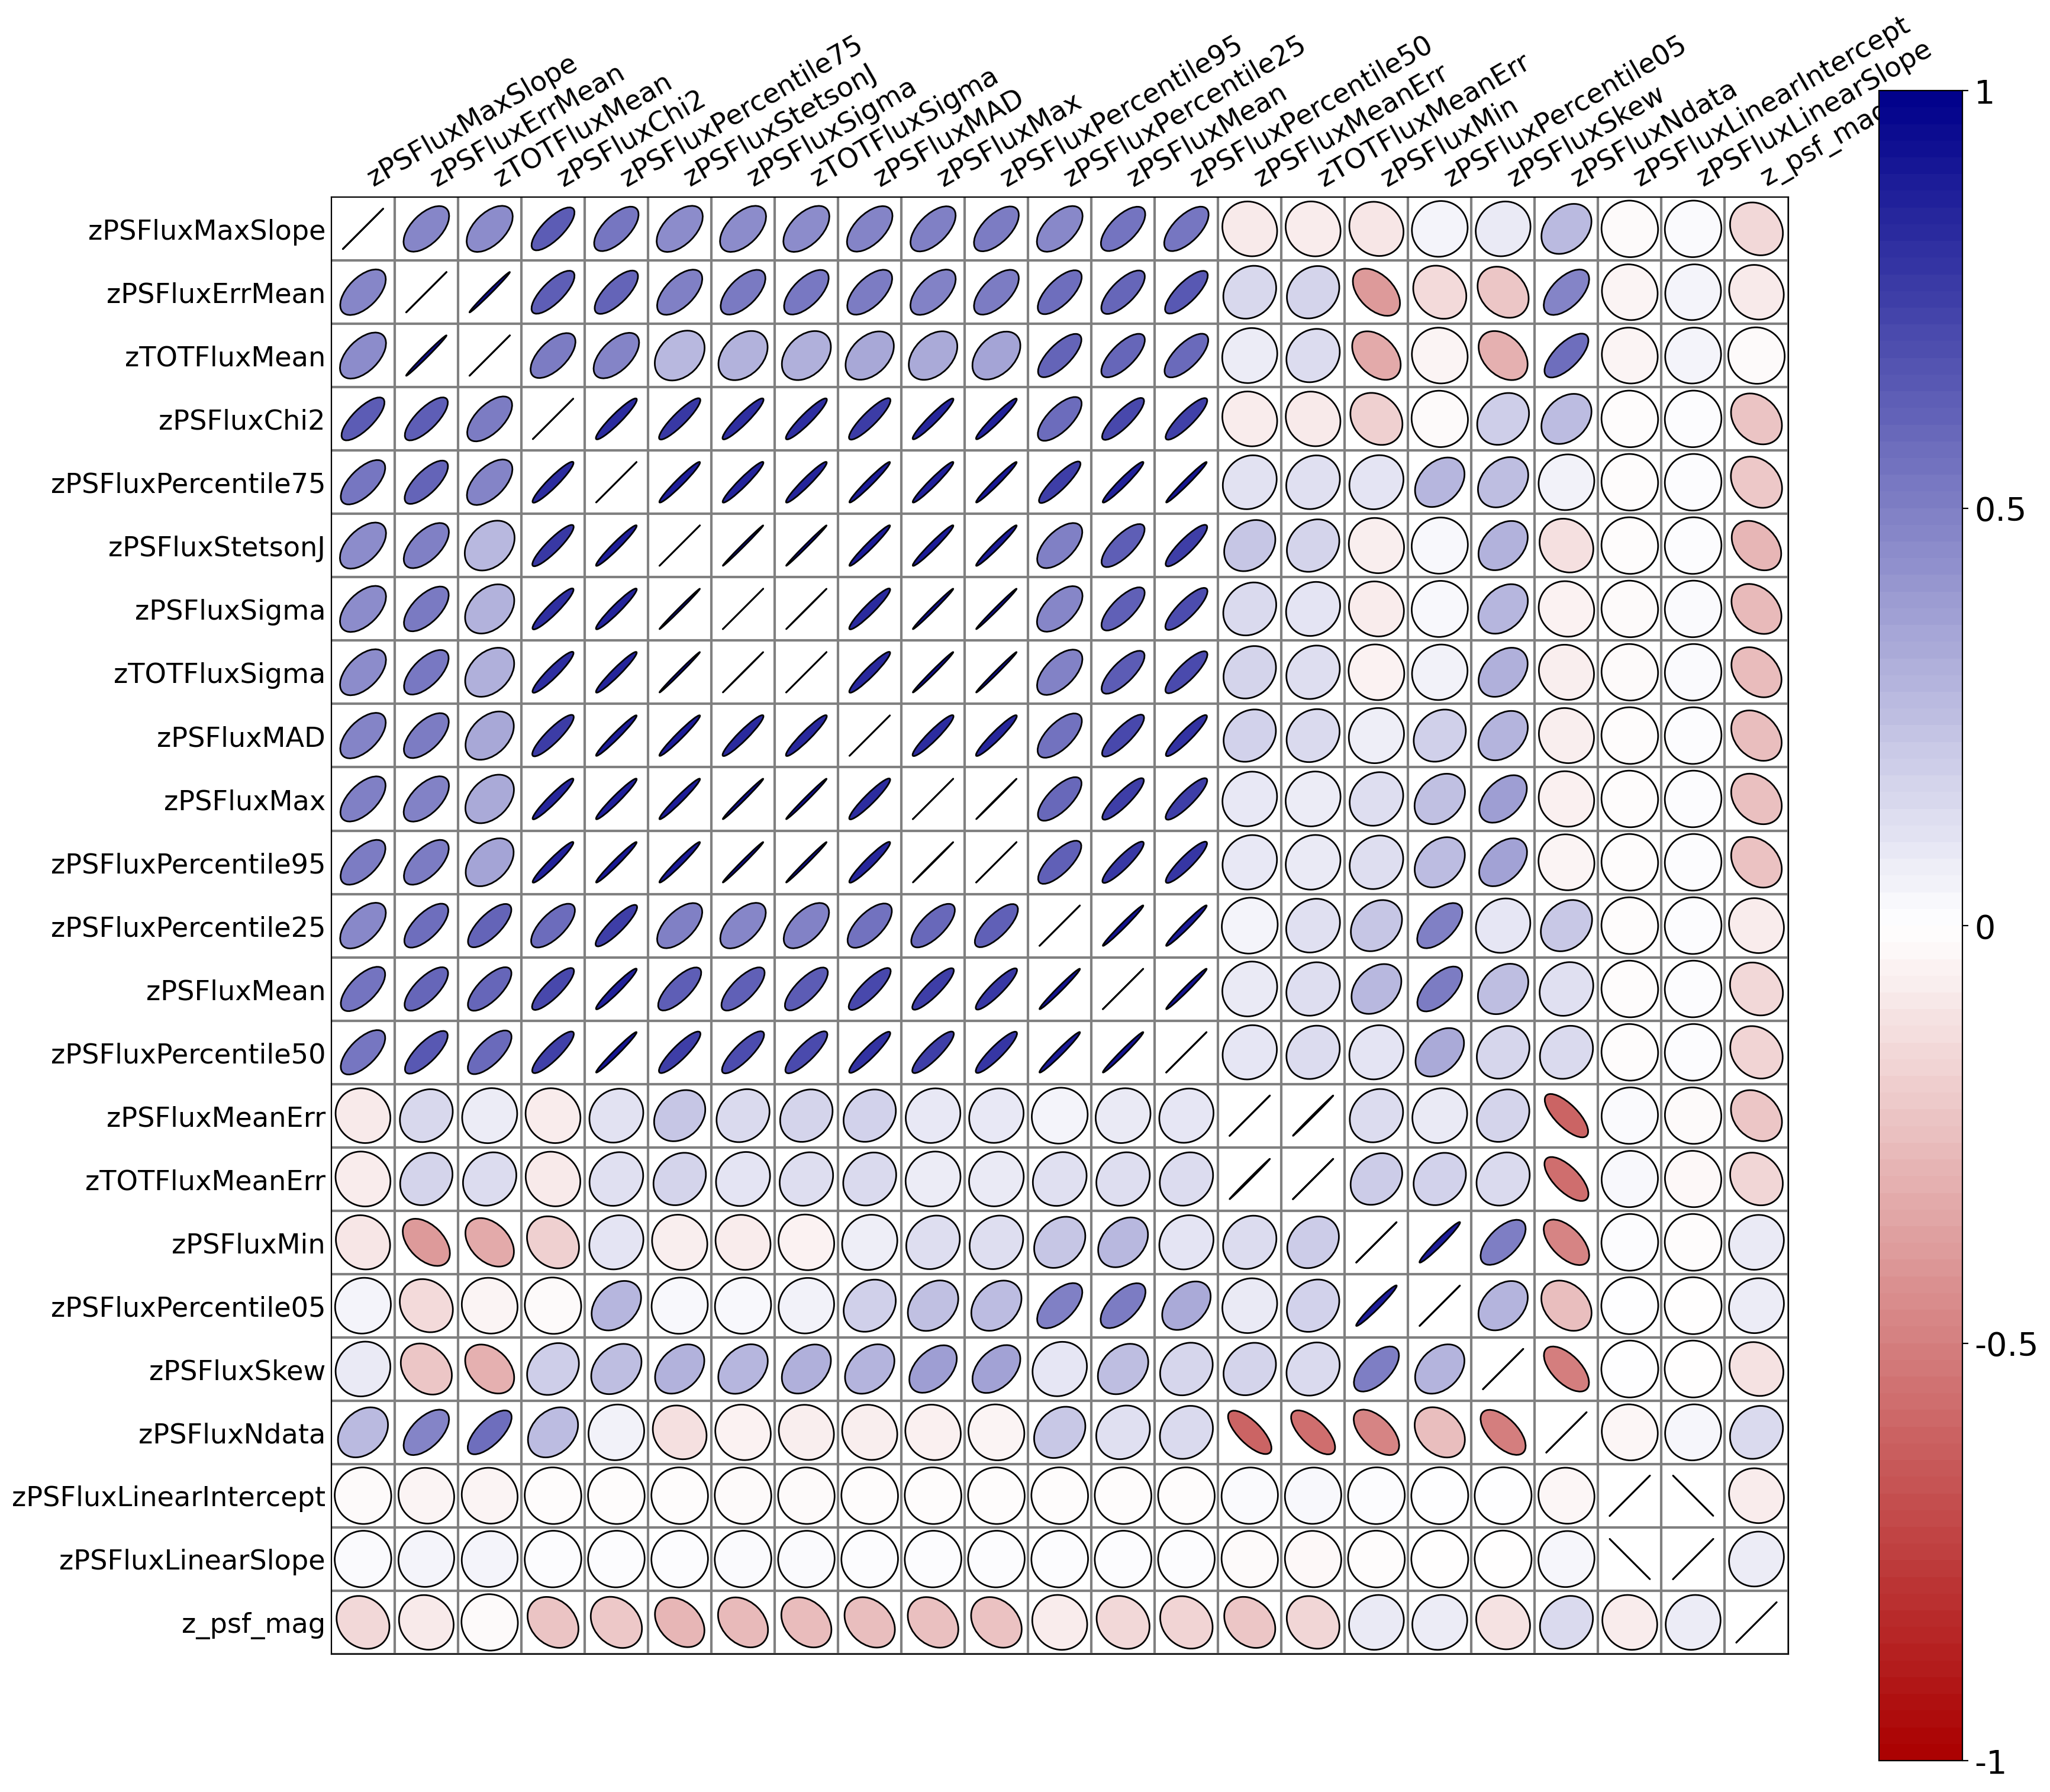

In [63]:
_cols = [col for col in data.columns if col.startswith('z')]

# create a correlation-like data set stored in a Pandas' dataframe.
import string
# letters = string.uppercase[0:10] # python2
letters = string.ascii_uppercase[0:10]
import pandas as pd


# and use corrplot
from biokit.viz import corrplot
fig = plt.figure(figsize=(20, 20))
c = corrplot.Corrplot(data.loc[:,_cols])
c.plot(fig)